<a href="https://colab.research.google.com/github/Shrey-Viradiya/Deep-Reinforcement-Learning-and-GANs/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir quickdraw_data
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/apple.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/bulldozer.npy ./quickdraw_data/
!gsutil cp gs://quickdraw_dataset/full/numpy_bitmap/camouflage.npy ./quickdraw_data/
!gsutil cp "gs://quickdraw_dataset/full/numpy_bitmap/diving board.npy" ./quickdraw_data/

Copying gs://quickdraw_dataset/full/numpy_bitmap/apple.npy...
/ [1 files][108.2 MiB/108.2 MiB]                                                
Operation completed over 1 objects/108.2 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/airplane.npy...
| [1 files][113.4 MiB/113.4 MiB]                                                
Operation completed over 1 objects/113.4 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/bulldozer.npy...
/ [1 files][140.1 MiB/140.1 MiB]                                                
Operation completed over 1 objects/140.1 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/camouflage.npy...
/ [1 files][129.1 MiB/129.1 MiB]                                                
Operation completed over 1 objects/129.1 MiB.                                    
Copying gs://quickdraw_dataset/full/numpy_bitmap/diving board.npy...
\ [1 files][217.0 M

In [ ]:
!nvidia-smi

Sun Jul 12 14:22:23 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# GAN

In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd

### Load images

In [ ]:
apple_images = './quickdraw_data/apple.npy'

### Discriminator Network

In [ ]:
def discriminator_builder(img_w, img_h,width = 64, p = 0.4):
    
    # define inputs
    
    inputs = keras.layers.Input((img_w, img_h,1))
    
    # convolutional layers
    conv1 = keras.layers.Conv2D(width*1, 5, strides=2, padding='same', activation='relu')(inputs)
    conv1 = keras.layers.Dropout(p)(conv1)
    
    conv2 = keras.layers.Conv2D(width*2, 5, strides=2, padding='same', activation='relu')(conv1)
    conv2 = keras.layers.Dropout(p)(conv2)
    
    conv3 = keras.layers.Conv2D(width*4, 5, strides=2, padding='same', activation='relu')(conv2)
    conv3 = keras.layers.Dropout(p)(conv3)
    
    conv4 = keras.layers.Conv2D(width*8, 5, strides=1, padding='same', activation='relu')(conv3)
    conv4 = keras.layers.Flatten()(keras.layers.Dropout(p)(conv4))
    
    output = keras.layers.Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model

### Generator Network

In [ ]:
def generator_builder(z_dim=100,width=64,p=0.4):
    
    # Define inputs
    inputs = keras.layers.Input((z_dim,))
    
    # First dense layer
    dense1 = keras.layers.Dense(7*7*64)(inputs)
    dense1 = keras.layers.BatchNormalization(momentum = 0.9)(dense1)
    dense1 = keras.layers.Activation(activation = 'relu')(dense1)
    dense1 = keras.layers.Reshape((7,7,64))(dense1)
    dense1 = keras.layers.Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = keras.layers.UpSampling2D()(dense1)
    conv1 = keras.layers.Conv2DTranspose(int(width / 2), kernel_size = 5, padding = 'same', activation = None,)(conv1)
    conv1 = keras.layers.BatchNormalization(momentum=0.9)(conv1)
    conv1 = keras.layers.Activation(activation='relu')(conv1)
    
    conv2 = keras.layers.UpSampling2D()(conv1)
    conv2 = keras.layers.Conv2DTranspose(int(width / 4), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv2 = keras.layers.BatchNormalization(momentum=0.9)(conv2)
    conv2 = keras.layers.Activation(activation='relu')(conv2)
    
    conv3 = keras.layers.Conv2DTranspose(int(width / 8), kernel_size = 5, padding = 'same', activation = None,)(conv2)
    conv3 = keras.layers.BatchNormalization(momentum=0.9)(conv3)
    conv3 = keras.layers.Activation(activation='relu')(conv3)
    
    output = keras.layers.Conv2D(1, kernel_size=5, padding='same', activation='sigmoid')(conv3)
    
    model = keras.models.Model(inputs=inputs, outputs=output)
    model.summary()
    
    return model


### Create adversarial network¶

In [ ]:
def adversarial_builder(generator, discriminator):
    model = keras.models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', 
                  optimizer=keras.optimizers.RMSprop(lr=0.0004, decay=3e-8, clipvalue=1.0), 
                  metrics=['accuracy'])
    model.summary()
    return model

### Train

In [ ]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

In [ ]:
def train(adversarial_model,data,epochs=2000,batch=128):
    
    generator, discriminator = adversarial_model.layers

    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        if i%100 == 0:
            print(i)
        
        real_imgs = np.reshape(data[np.random.choice(data.shape[0],batch,replace=False)],(batch,28,28,1))
        fake_imgs = generator.predict(np.random.uniform(-1.0, 1.0, size=[batch, 100]))

        x = np.concatenate((real_imgs,fake_imgs))
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        make_trainable(discriminator, True)
        
        d_metrics.append(discriminator.train_on_batch(x,y))
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        make_trainable(discriminator, False)
        
        noise = np.random.uniform(-1.0, 1.0, size=[batch, 100])
        y = np.ones([batch,1])

        a_metrics.append(adversarial_model.train_on_batch(noise,y)) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        if (i+1)%500 == 0:

            print('Epoch #{}'.format(i+1))
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, size=[16, 100])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

## Engine

In [ ]:
def GAN_engine(path_to_npy):
    data = np.load(path_to_npy)

    data = data/255
    data = np.reshape(data, (data.shape[0],28,28,1))
    img_w, img_h = data.shape[1:3]

    discriminator = discriminator_builder(img_w, img_h)
    discriminator.compile(loss='binary_crossentropy', 
                      optimizer=keras.optimizers.RMSprop(lr=0.0008, decay=6e-8, clipvalue=1.0), 
                      metrics=['accuracy'])
    
    generator = generator_builder()

    adversarial_model = adversarial_builder(generator, discriminator)

    a_metrics_complete, d_metrics_complete = train(adversarial_model,data, epochs=10000)

    ax = pd.DataFrame(
    {
        'Generator': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
    ).plot(title='Training Loss', logy=True)
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")

    ax = pd.DataFrame(
    {
        'Generator': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
    ).plot(title='Training Accuracy')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 256)         0     

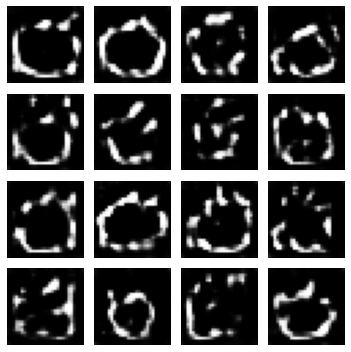

500
600
700
800
900
Epoch #1000
999: [D loss: 0.544371, acc: 0.765492]  [A loss: 1.910406, acc: 0.116116]


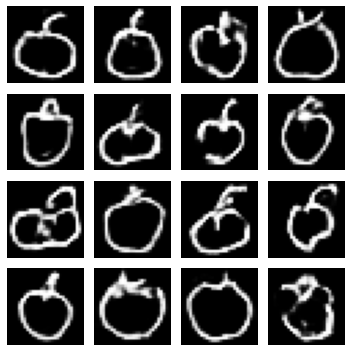

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.559799, acc: 0.741307]  [A loss: 1.705961, acc: 0.118360]


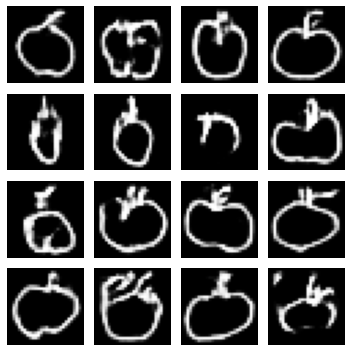

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.564043, acc: 0.733924]  [A loss: 1.631008, acc: 0.117324]


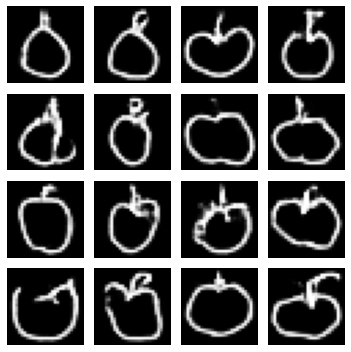

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.568514, acc: 0.729300]  [A loss: 1.611246, acc: 0.116775]


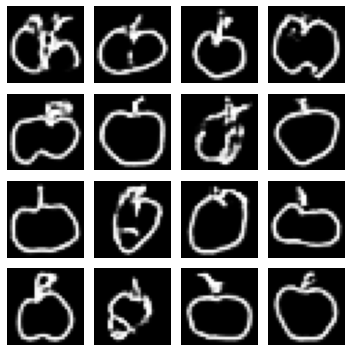

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.571138, acc: 0.728326]  [A loss: 1.650870, acc: 0.116015]


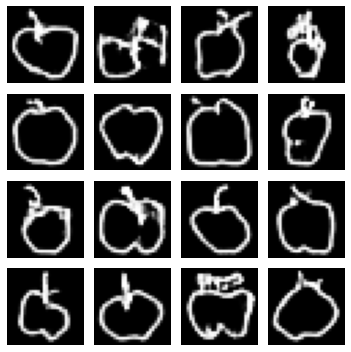

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.576075, acc: 0.727178]  [A loss: 1.717291, acc: 0.116261]


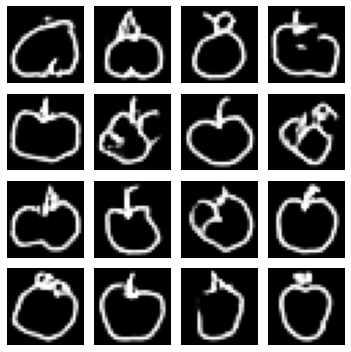

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.579129, acc: 0.726224]  [A loss: 1.777507, acc: 0.116123]


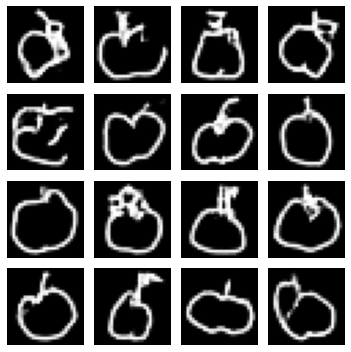

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.580979, acc: 0.725839]  [A loss: 1.832136, acc: 0.116172]


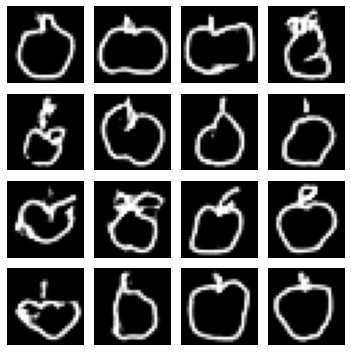

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.587530, acc: 0.722977]  [A loss: 1.868656, acc: 0.118349]


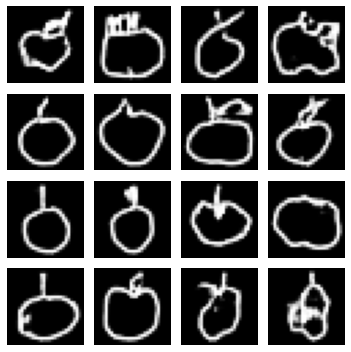

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.590382, acc: 0.720971]  [A loss: 1.893448, acc: 0.119820]


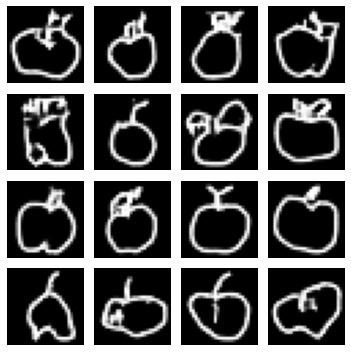

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.591887, acc: 0.719153]  [A loss: 1.907692, acc: 0.121104]


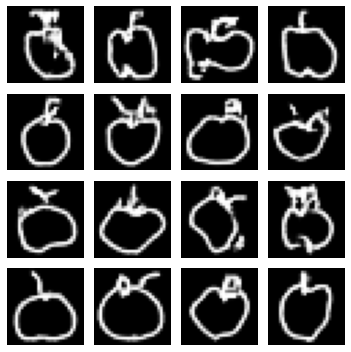

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.593627, acc: 0.717369]  [A loss: 1.914806, acc: 0.122280]


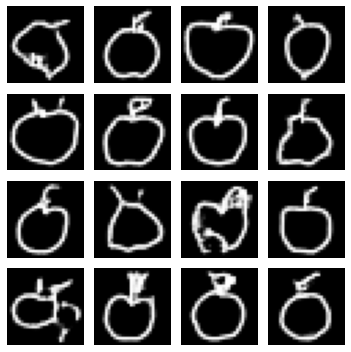

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.595051, acc: 0.715671]  [A loss: 1.908371, acc: 0.123443]


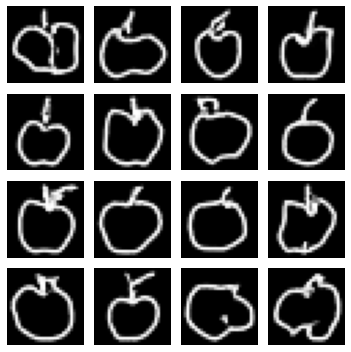

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.596686, acc: 0.713585]  [A loss: 1.897385, acc: 0.125138]


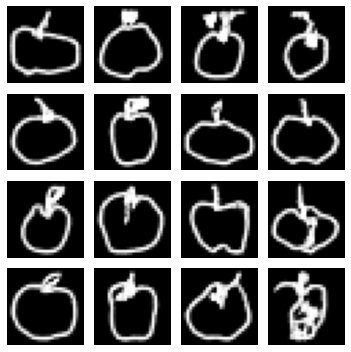

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.598643, acc: 0.711401]  [A loss: 1.881921, acc: 0.127189]


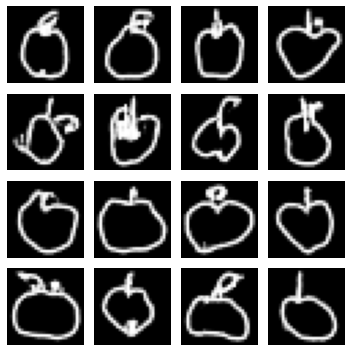

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.601092, acc: 0.708813]  [A loss: 1.858884, acc: 0.129073]


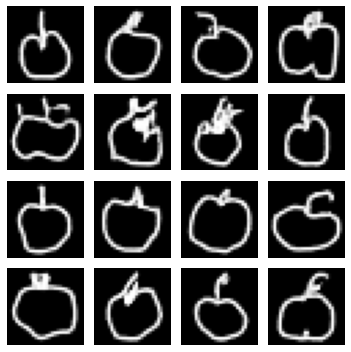

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.603543, acc: 0.706282]  [A loss: 1.834220, acc: 0.130929]


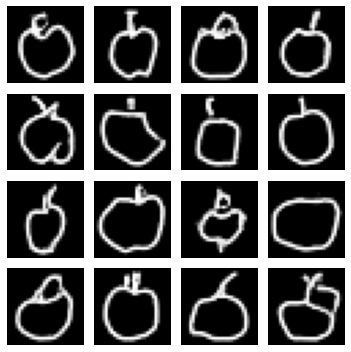

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.605920, acc: 0.703635]  [A loss: 1.809886, acc: 0.132713]


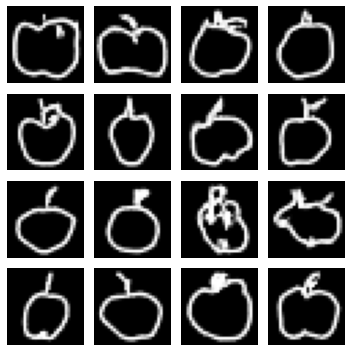

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.608414, acc: 0.700857]  [A loss: 1.784593, acc: 0.134474]


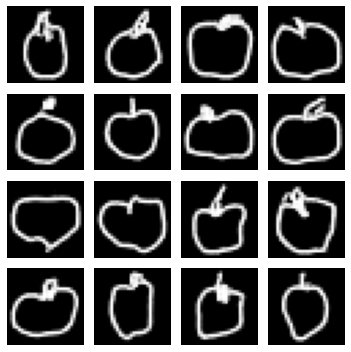

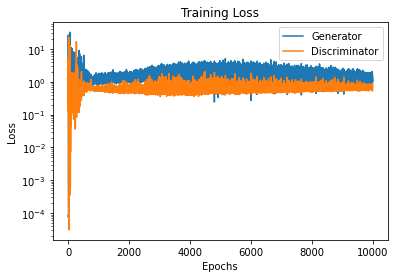

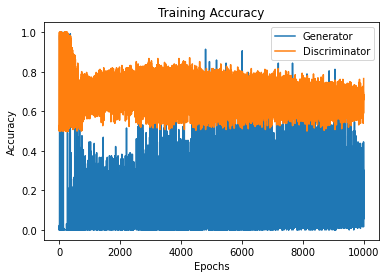

In [ ]:
GAN_engine(apple_images)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_5 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_6 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 256)         0   

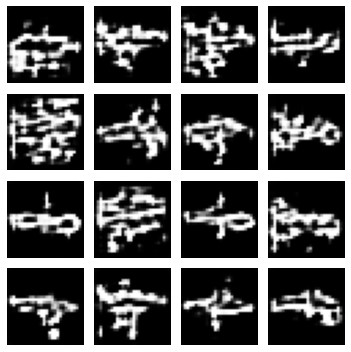

500
600
700
800
900
Epoch #1000
999: [D loss: 0.575493, acc: 0.700024]  [A loss: 1.482633, acc: 0.134674]


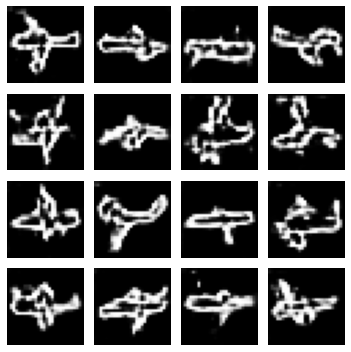

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.583440, acc: 0.694043]  [A loss: 1.417470, acc: 0.129790]


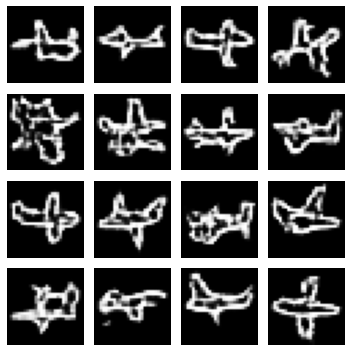

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.583875, acc: 0.697460]  [A loss: 1.442458, acc: 0.124222]


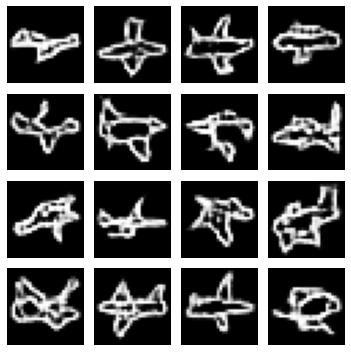

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.577222, acc: 0.705201]  [A loss: 1.502028, acc: 0.119185]


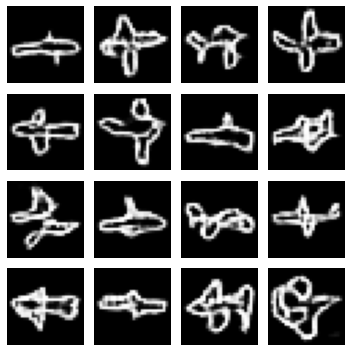

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.569064, acc: 0.713845]  [A loss: 1.578534, acc: 0.114869]


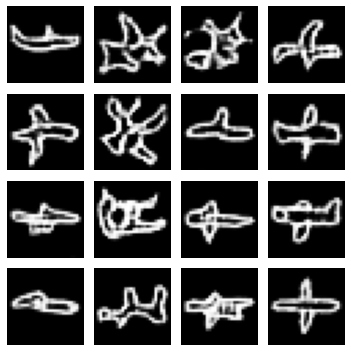

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.565944, acc: 0.719078]  [A loss: 1.665949, acc: 0.112157]


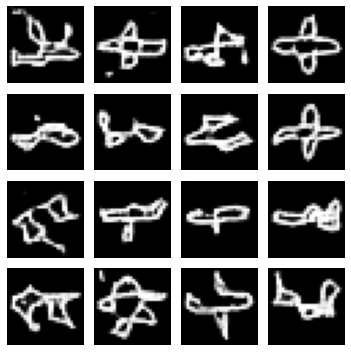

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.565685, acc: 0.722785]  [A loss: 1.762832, acc: 0.110156]


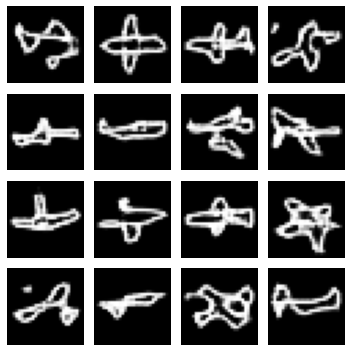

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.566671, acc: 0.724663]  [A loss: 1.837694, acc: 0.109076]


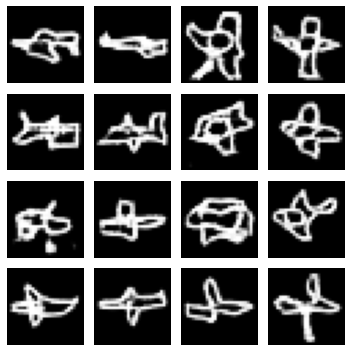

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.568024, acc: 0.725848]  [A loss: 1.895239, acc: 0.108661]


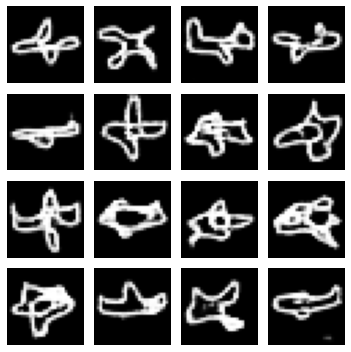

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.567733, acc: 0.726742]  [A loss: 1.932439, acc: 0.108528]


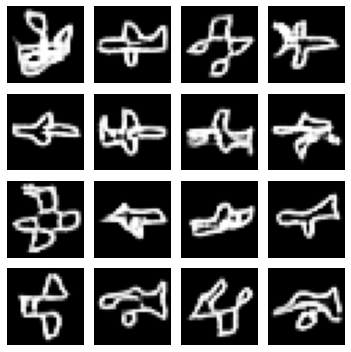

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.568262, acc: 0.727429]  [A loss: 1.973975, acc: 0.108471]


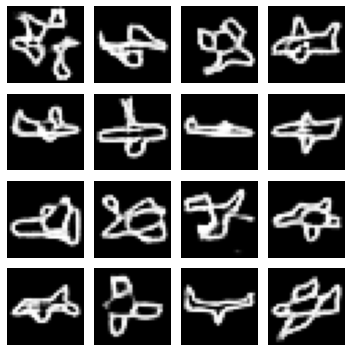

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.567900, acc: 0.728353]  [A loss: 1.999882, acc: 0.108566]


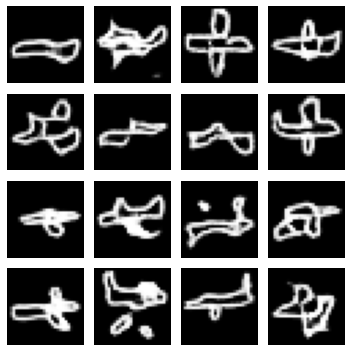

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.568077, acc: 0.729216]  [A loss: 2.026708, acc: 0.108443]


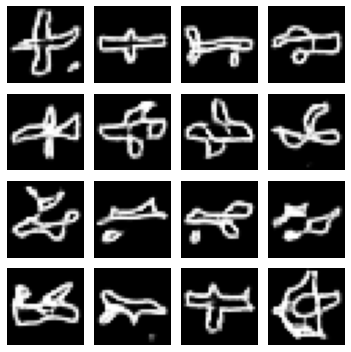

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.569483, acc: 0.729156]  [A loss: 2.041115, acc: 0.108948]


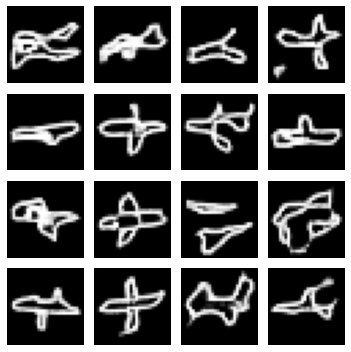

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.570983, acc: 0.728839]  [A loss: 2.046156, acc: 0.109594]


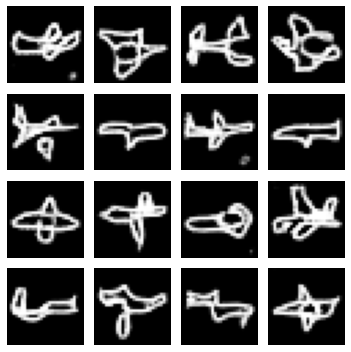

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.572393, acc: 0.728402]  [A loss: 2.051099, acc: 0.110590]


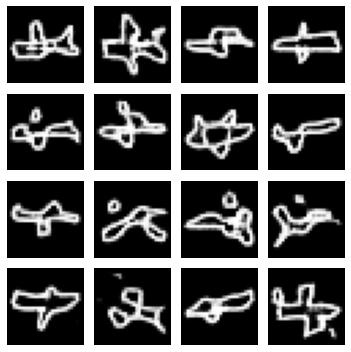

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.574068, acc: 0.727807]  [A loss: 2.051307, acc: 0.111641]


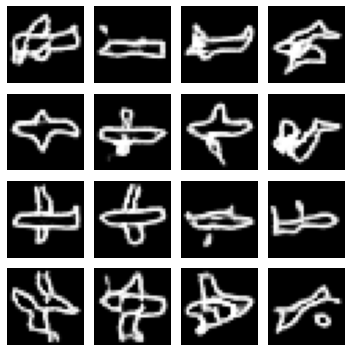

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.575782, acc: 0.727143]  [A loss: 2.048141, acc: 0.112637]


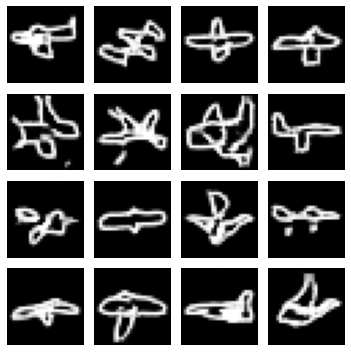

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.577417, acc: 0.726377]  [A loss: 2.043208, acc: 0.113568]


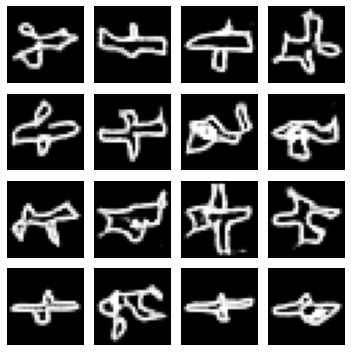

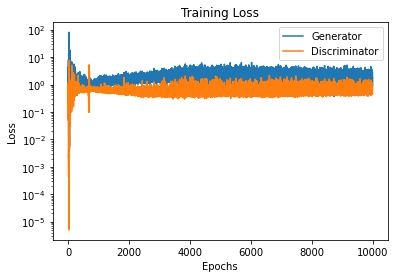

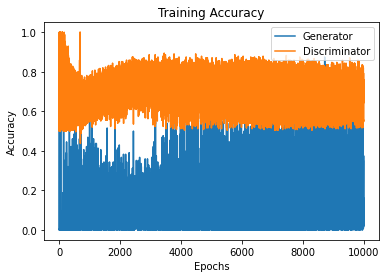

In [ ]:
airplane_images = './quickdraw_data/airplane.npy'
GAN_engine(airplane_images)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_12 (Dropout)         (None, 4, 4, 256)         0   

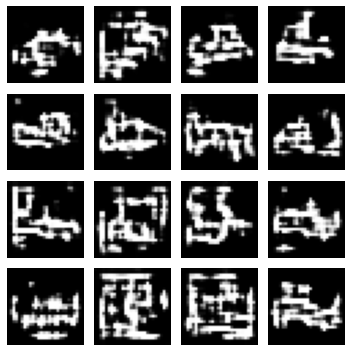

500
600
700
800
900
Epoch #1000
999: [D loss: 0.603354, acc: 0.683652]  [A loss: 1.346931, acc: 0.163812]


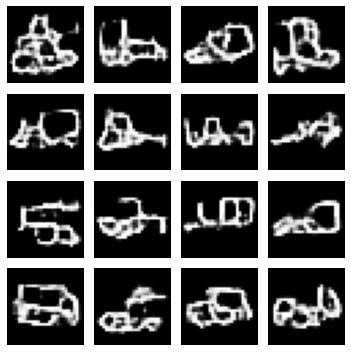

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.615786, acc: 0.669608]  [A loss: 1.332834, acc: 0.160435]


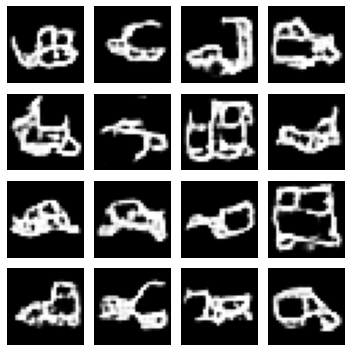

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.608531, acc: 0.678423]  [A loss: 1.421988, acc: 0.151185]


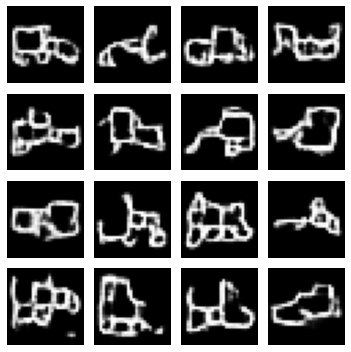

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.601718, acc: 0.687086]  [A loss: 1.531149, acc: 0.144730]


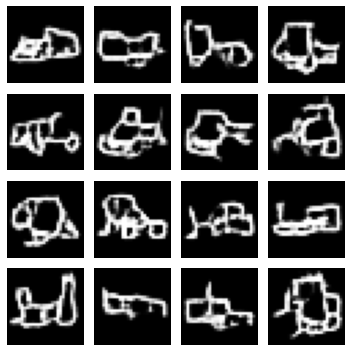

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.598686, acc: 0.690958]  [A loss: 1.574104, acc: 0.139919]


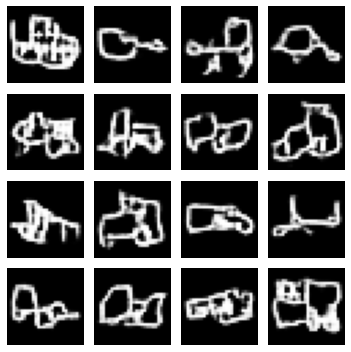

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.595258, acc: 0.693521]  [A loss: 1.591131, acc: 0.135936]


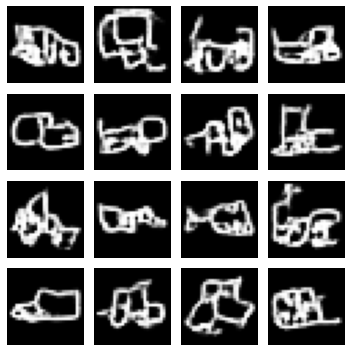

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.595946, acc: 0.695523]  [A loss: 1.589304, acc: 0.131234]


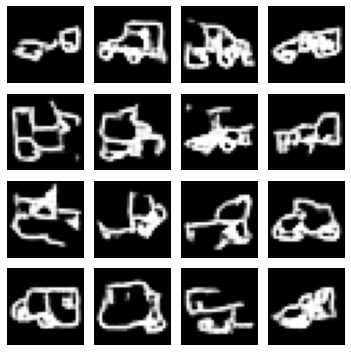

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.599988, acc: 0.696305]  [A loss: 1.569163, acc: 0.128214]


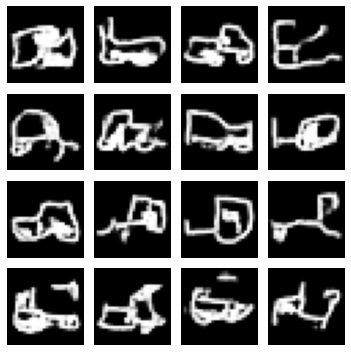

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.605008, acc: 0.694520]  [A loss: 1.517650, acc: 0.128343]


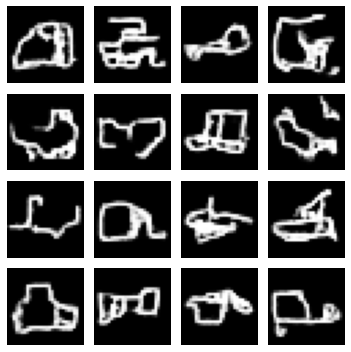

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.610353, acc: 0.691661]  [A loss: 1.454585, acc: 0.129200]


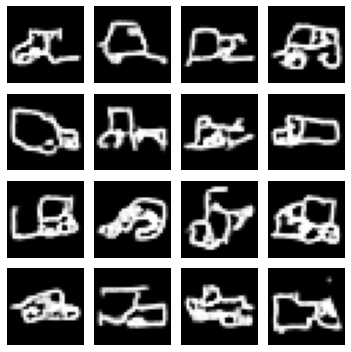

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.612485, acc: 0.690999]  [A loss: 1.404428, acc: 0.129063]


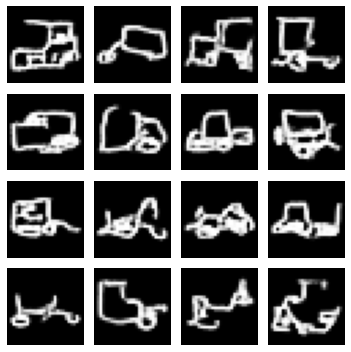

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.612731, acc: 0.691786]  [A loss: 1.364564, acc: 0.128119]


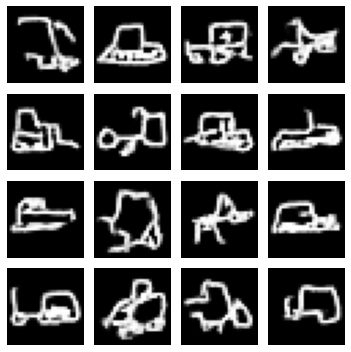

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.612598, acc: 0.692828]  [A loss: 1.333389, acc: 0.126738]


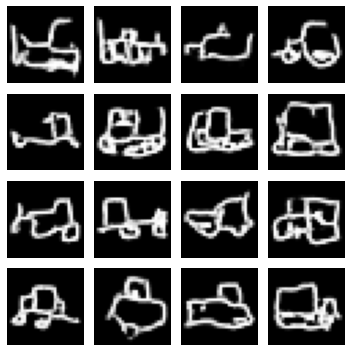

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.610665, acc: 0.695374]  [A loss: 1.321018, acc: 0.124668]


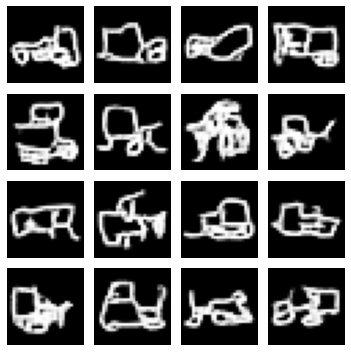

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.612066, acc: 0.695074]  [A loss: 1.303086, acc: 0.124106]


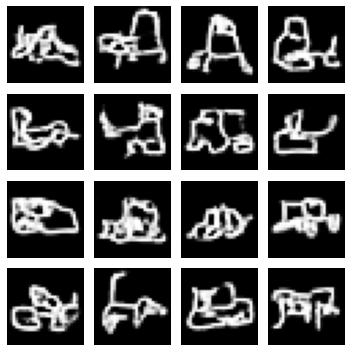

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.613325, acc: 0.694417]  [A loss: 1.283756, acc: 0.123980]


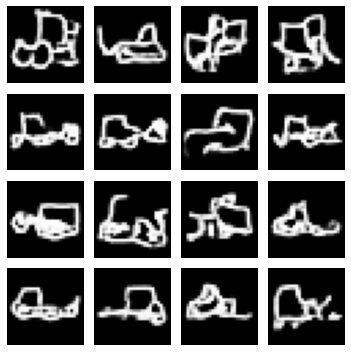

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.614127, acc: 0.693963]  [A loss: 1.267121, acc: 0.123797]


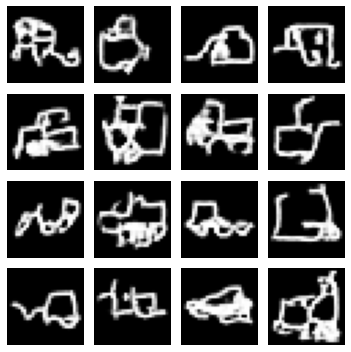

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.615110, acc: 0.693265]  [A loss: 1.252742, acc: 0.123659]


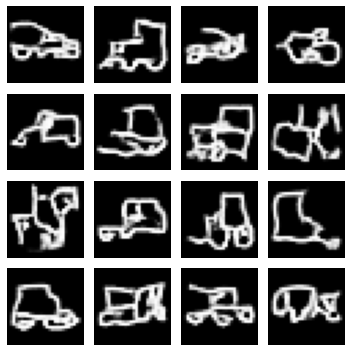

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.616045, acc: 0.692536]  [A loss: 1.240194, acc: 0.123625]


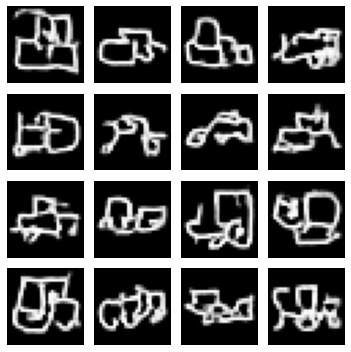

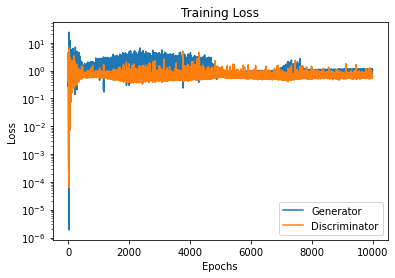

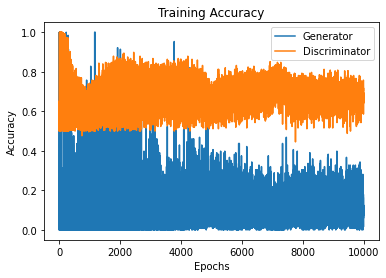

In [ ]:
bulldozer_images = './quickdraw_data/bulldozer.npy'
GAN_engine(bulldozer_images)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_15 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_16 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 256)         0   

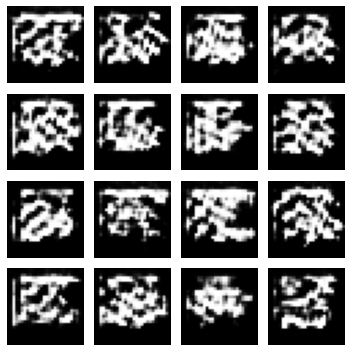

500
600
700
800
900
Epoch #1000
999: [D loss: 0.639569, acc: 0.651065]  [A loss: 1.336218, acc: 0.223966]


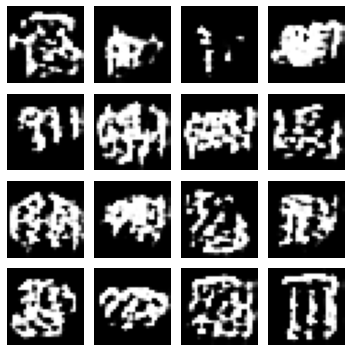

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.656482, acc: 0.625117]  [A loss: 1.175891, acc: 0.229116]


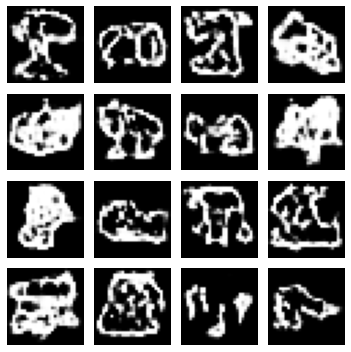

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.670973, acc: 0.604967]  [A loss: 1.070030, acc: 0.245150]


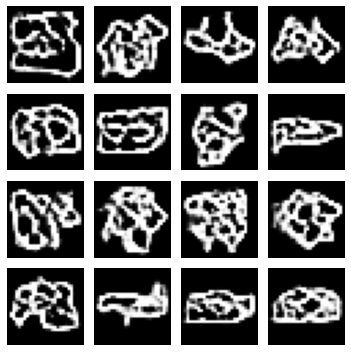

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.680665, acc: 0.589244]  [A loss: 1.003200, acc: 0.251576]


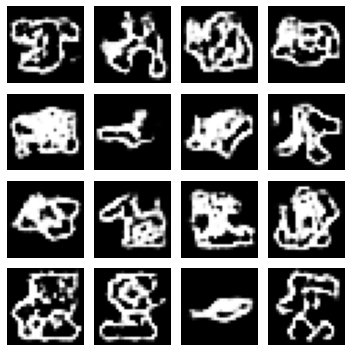

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.685062, acc: 0.578449]  [A loss: 0.959519, acc: 0.252631]


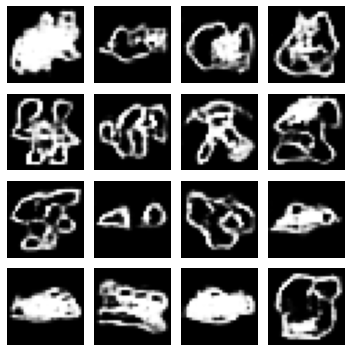

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.689444, acc: 0.570675]  [A loss: 0.929310, acc: 0.252119]


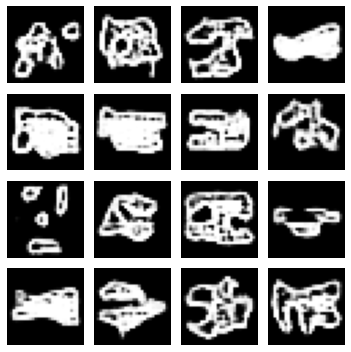

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.692964, acc: 0.564955]  [A loss: 0.908293, acc: 0.248758]


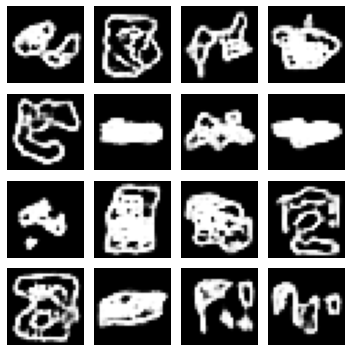

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.694915, acc: 0.561272]  [A loss: 0.892439, acc: 0.247894]


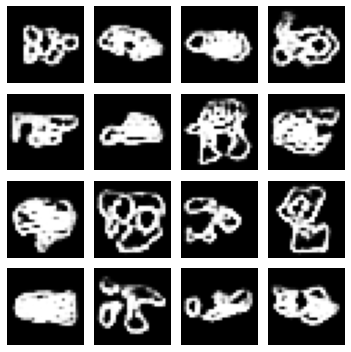

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.696672, acc: 0.559336]  [A loss: 0.879040, acc: 0.247534]


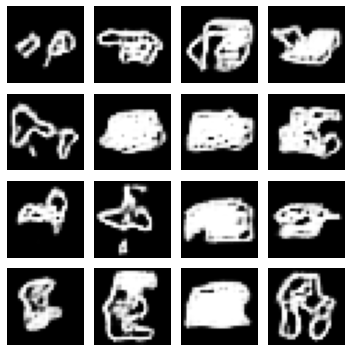

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.698399, acc: 0.557893]  [A loss: 0.868837, acc: 0.244378]


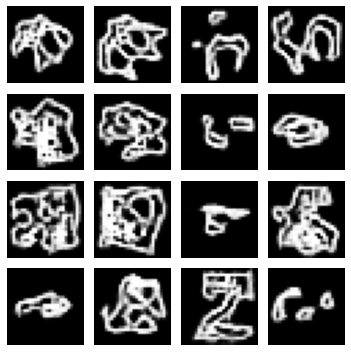

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.699636, acc: 0.557030]  [A loss: 0.860811, acc: 0.239246]


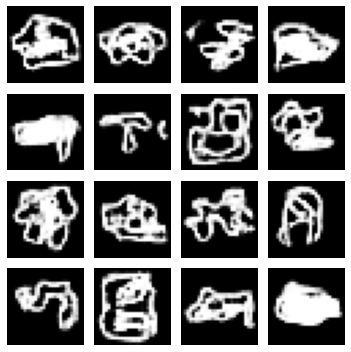

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.701142, acc: 0.555269]  [A loss: 0.851991, acc: 0.240038]


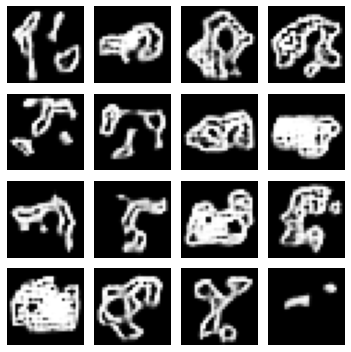

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.701913, acc: 0.553849]  [A loss: 0.845981, acc: 0.236101]


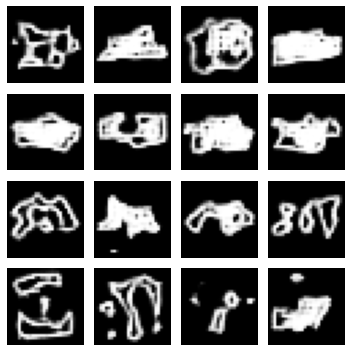

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.702638, acc: 0.552228]  [A loss: 0.839022, acc: 0.235426]


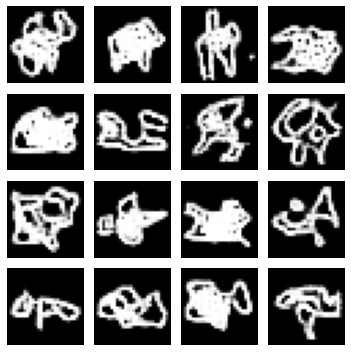

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.703573, acc: 0.551585]  [A loss: 0.833388, acc: 0.232914]


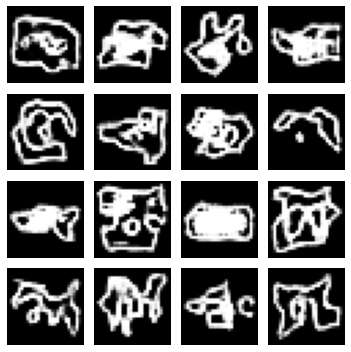

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.704277, acc: 0.550414]  [A loss: 0.828782, acc: 0.230777]


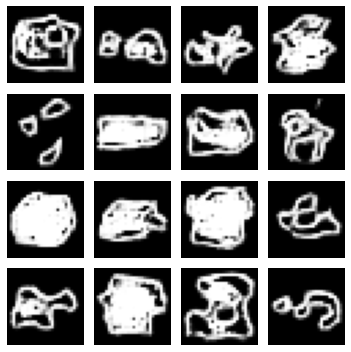

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.705049, acc: 0.549434]  [A loss: 0.824336, acc: 0.229627]


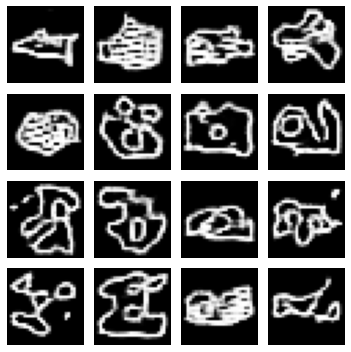

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.705523, acc: 0.548105]  [A loss: 0.820258, acc: 0.229616]


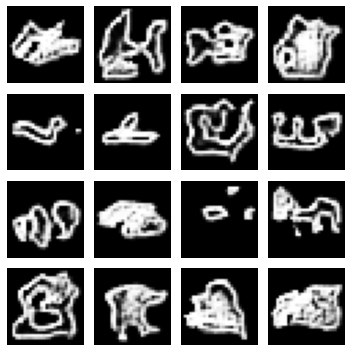

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.706008, acc: 0.546977]  [A loss: 0.817067, acc: 0.228010]


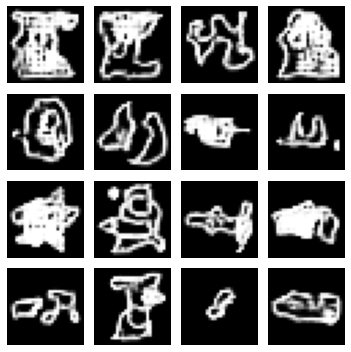

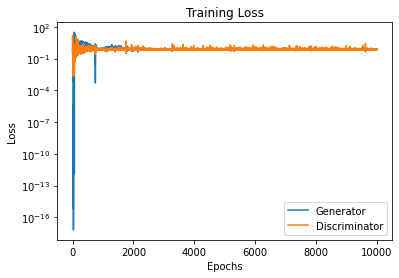

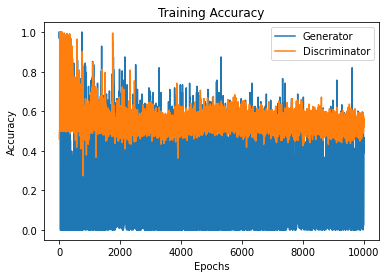

In [ ]:
camouflage_images = './quickdraw_data/camouflage.npy'
GAN_engine(camouflage_images)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_21 (Dropout)         (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 4, 256)         0   

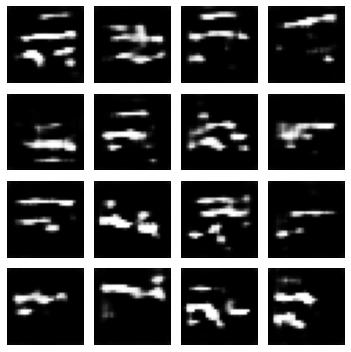

500
600
700
800
900
Epoch #1000
999: [D loss: 0.554563, acc: 0.716944]  [A loss: 1.565566, acc: 0.177068]


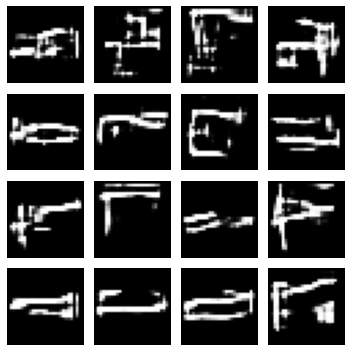

1000
1100
1200
1300
1400
Epoch #1500
1499: [D loss: 0.597154, acc: 0.682859]  [A loss: 1.458876, acc: 0.169478]


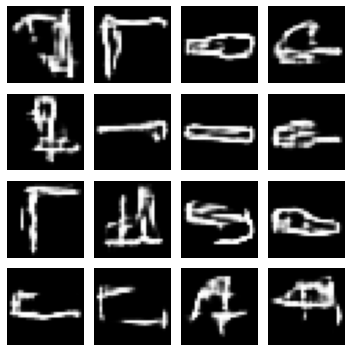

1500
1600
1700
1800
1900
Epoch #2000
1999: [D loss: 0.622745, acc: 0.662960]  [A loss: 1.386804, acc: 0.170706]


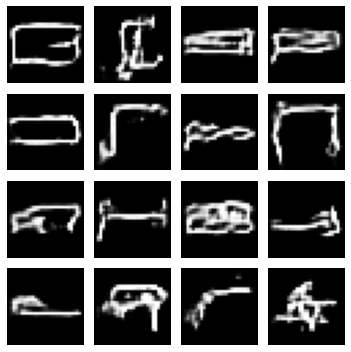

2000
2100
2200
2300
2400
Epoch #2500
2499: [D loss: 0.634144, acc: 0.653363]  [A loss: 1.314552, acc: 0.172441]


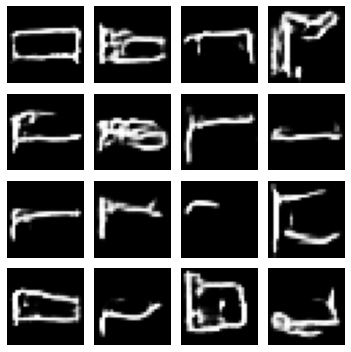

2500
2600
2700
2800
2900
Epoch #3000
2999: [D loss: 0.636141, acc: 0.652820]  [A loss: 1.265971, acc: 0.167939]


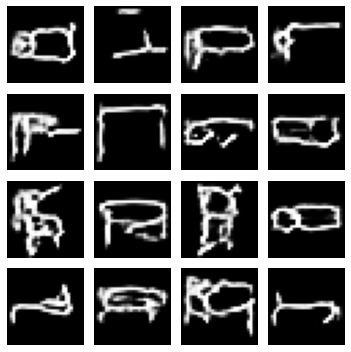

3000
3100
3200
3300
3400
Epoch #3500
3499: [D loss: 0.632798, acc: 0.656612]  [A loss: 1.246393, acc: 0.161731]


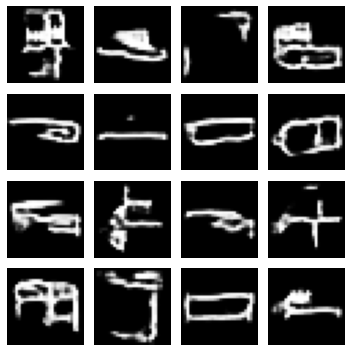

3500
3600
3700
3800
3900
Epoch #4000
3999: [D loss: 0.626965, acc: 0.663086]  [A loss: 1.237204, acc: 0.153734]


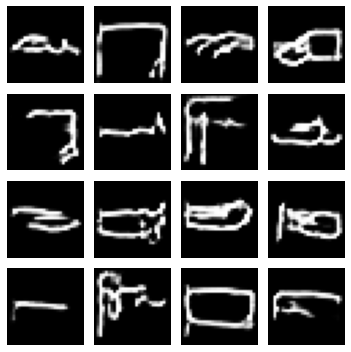

4000
4100
4200
4300
4400
Epoch #4500
4499: [D loss: 0.622665, acc: 0.668850]  [A loss: 1.229836, acc: 0.146157]


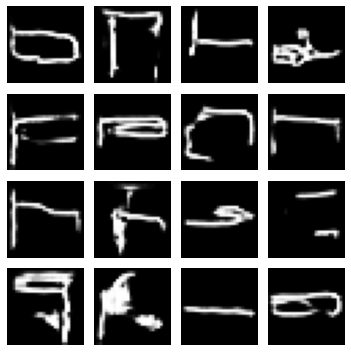

4500
4600
4700
4800
4900
Epoch #5000
4999: [D loss: 0.619224, acc: 0.673852]  [A loss: 1.215343, acc: 0.140414]


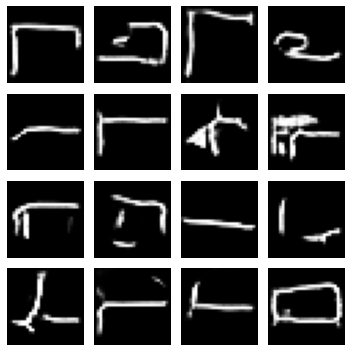

5000
5100
5200
5300
5400
Epoch #5500
5499: [D loss: 0.616790, acc: 0.677244]  [A loss: 1.198635, acc: 0.136253]


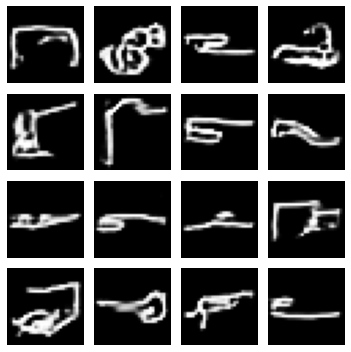

5500
5600
5700
5800
5900
Epoch #6000
5999: [D loss: 0.616959, acc: 0.677782]  [A loss: 1.179912, acc: 0.133787]


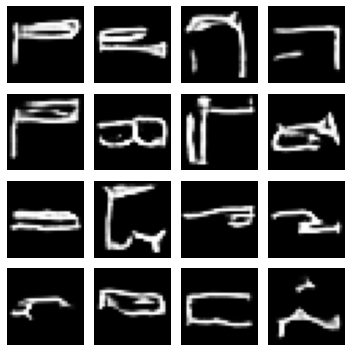

6000
6100
6200
6300
6400
Epoch #6500
6499: [D loss: 0.615768, acc: 0.679177]  [A loss: 1.165988, acc: 0.131856]


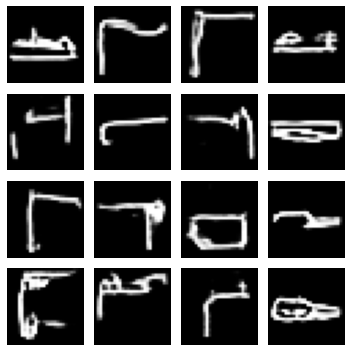

6500
6600
6700
6800
6900
Epoch #7000
6999: [D loss: 0.614000, acc: 0.681072]  [A loss: 1.156377, acc: 0.129349]


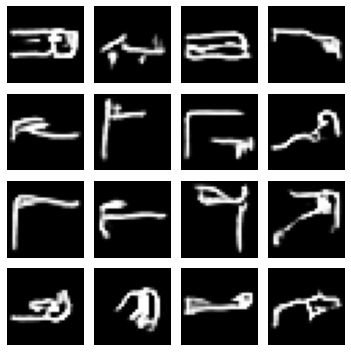

7000
7100
7200
7300
7400
Epoch #7500
7499: [D loss: 0.611912, acc: 0.683208]  [A loss: 1.149271, acc: 0.127408]


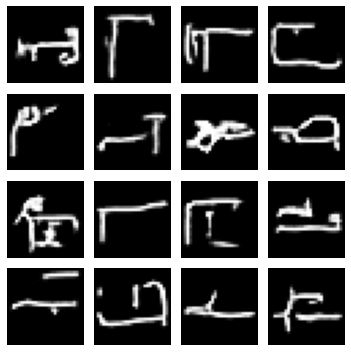

7500
7600
7700
7800
7900
Epoch #8000
7999: [D loss: 0.609503, acc: 0.685622]  [A loss: 1.145416, acc: 0.125186]


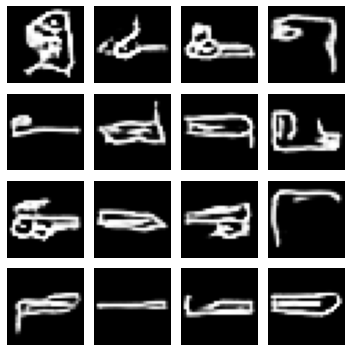

8000
8100
8200
8300
8400
Epoch #8500
8499: [D loss: 0.606565, acc: 0.688439]  [A loss: 1.143960, acc: 0.122798]


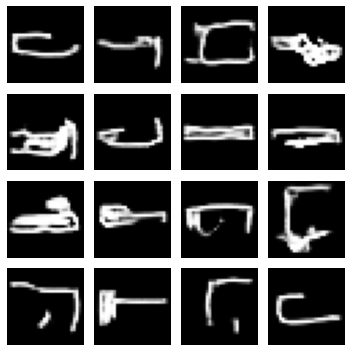

8500
8600
8700
8800
8900
Epoch #9000
8999: [D loss: 0.604689, acc: 0.690621]  [A loss: 1.143893, acc: 0.120729]


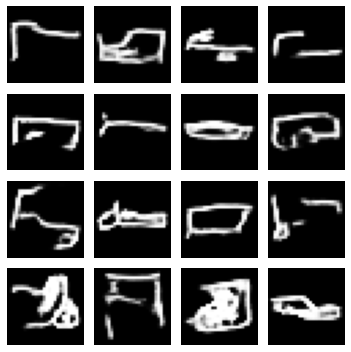

9000
9100
9200
9300
9400
Epoch #9500
9499: [D loss: 0.602596, acc: 0.692811]  [A loss: 1.144408, acc: 0.119293]


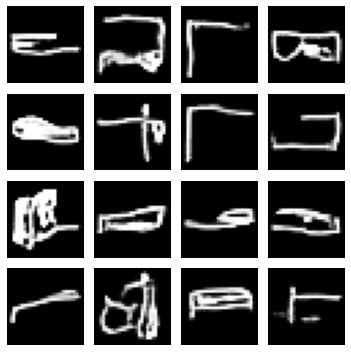

9500
9600
9700
9800
9900
Epoch #10000
9999: [D loss: 0.601366, acc: 0.694390]  [A loss: 1.145259, acc: 0.118094]


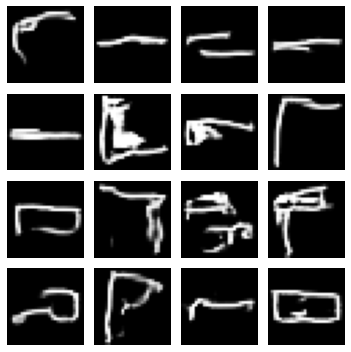

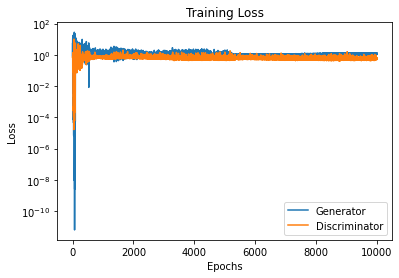

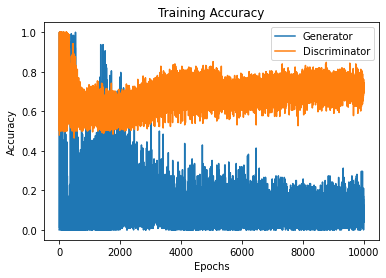

In [ ]:
diving_images = './quickdraw_data/diving board.npy'
GAN_engine(diving_images)